# mean_time의 Visualization
양이 많은 관계로 **501.csv**만 시각화하였음

In [8]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import matplotlib.pyplot as plt

In [9]:
# CSV file의 range 정하기
file_numbers = range(501, 519)  # 501 ~ 518
all_sequences = []

In [23]:
for num in file_numbers:
    filename = f'{num}.csv'
    print(f"Processing {filename}...")
    df = pd.read_csv(filename)
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # pandas 내장 시간함수
    df['second'] = df['timestamp'].dt.strftime('%Y-%m-%d %H:%M:%S')  # 년도-월-일 시간:분:초 까지만 추출

    # Sensor들의 mean 구하기
    sensor_means = df.groupby('second').mean().reset_index()

    #display(sensor_means)

    # label 지정
    all_labels = [1, 3, 4, 5, 6, 7, 8]

    # label distribution 계산. 이 때 unstack를 통해 등장하지 않은 label에도 0 할당
    label_distributions = df.groupby('second')['label'].apply(lambda x: x.value_counts(normalize=True)).unstack(fill_value=0).reindex(columns=all_labels, fill_value=0)

    # Merge
    final_df = pd.merge(sensor_means, label_distributions, on='second', how='left')

    # Final df 확인
    #display(final_df)
    
    # 30초씩 묶기
    num_rows = len(final_df) # 초의 개수
    row_count = 0
    while (row_count + 30 <= num_rows):
        segment = final_df.iloc[row_count:row_count + 30]
        next_label = final_df.iloc[row_count + 29][all_labels].values # 바로 다음을 예측하기 위해

        '''if num == 501:
            print(next_label)'''
        
        features = segment[['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z']].values
        
        all_sequences.append((features, next_label))

        '''if num == 501:
            print(all_sequences)'''

        row_count += 5

Processing 501.csv...
Processing 502.csv...
Processing 503.csv...
Processing 504.csv...
Processing 505.csv...
Processing 506.csv...
Processing 507.csv...
Processing 508.csv...
Processing 509.csv...
Processing 510.csv...
Processing 511.csv...
Processing 512.csv...
Processing 513.csv...
Processing 514.csv...
Processing 515.csv...
Processing 516.csv...
Processing 517.csv...
Processing 518.csv...


Training mode: X's shape -  torch.Size([40133, 30, 6]) Y's shape -  torch.Size([40133, 7])


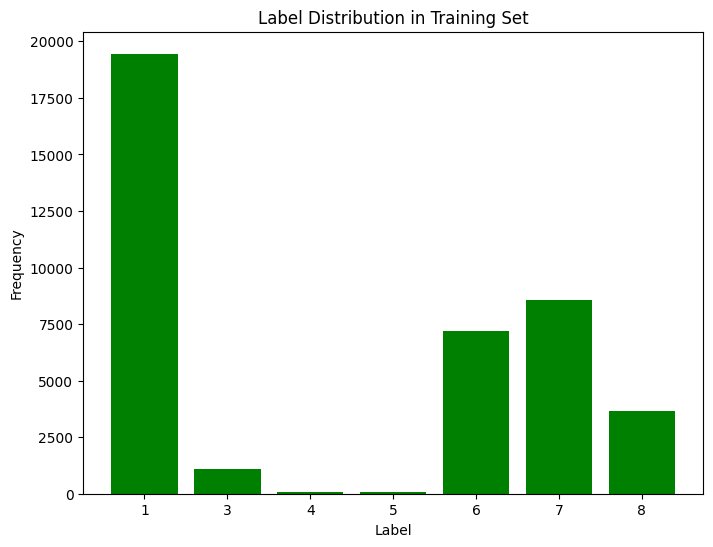

In [24]:
# Feature와 label 분리
features, labels = zip(*all_sequences)
X = np.array(features, dtype=np.float32)
Y = np.array(labels, dtype=np.float32)

# NumPy 배열을 텐서로 변환
X = torch.tensor(X, dtype=torch.float32)
Y = torch.tensor(Y, dtype=torch.float32)

# 7:3의 비율로 train / test 나누기
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

print("Training mode: X's shape - ", X_train.shape, "Y's shape - ", Y_train.shape)

# 저장
torch.save(X_train, 'training_set_X.tensor')
torch.save(X_test, 'test_set_X.tensor')
torch.save(Y_train, 'training_set_Y.tensor')
torch.save(Y_test, 'test_set_Y.tensor')

# 각 label의 분포 시각화
labels_count = Y_train.view(-1, len(all_labels)).argmax(dim=1).numpy()
plt.figure(figsize=(8, 6))
plt.hist(labels_count, bins=np.arange(len(all_labels)+1)-0.5, rwidth=0.8, color='green')
plt.title('Label Distribution in Training Set')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.xticks(range(len(all_labels)), all_labels)
plt.show()